In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score


In [76]:
calls = pd.read_csv('calls.csv')
customers = pd.read_csv('customers.csv')
reason = pd.read_csv('reason.csv')
senti_stats = pd.read_csv('sentiment_statistics.csv')

#### Merging the calls and customers csv

In [77]:
calls_customers = calls.merge(customers,how='inner',on='customer_id')

#### Merging reason.csv with calls_customers

In [78]:
df = calls_customers.merge(reason,how='left',on='call_id')

#### Merging all the csv files together

In [79]:
data = df.merge(senti_stats, how='inner',on='call_id')

In [80]:
data.isnull().sum()

call_id                        0
customer_id                    0
agent_id_x                     0
call_start_datetime            0
agent_assigned_datetime        0
call_end_datetime              0
call_transcript                0
customer_name                  0
elite_level_code           25767
primary_call_reason         5157
agent_id_y                     0
agent_tone                   217
customer_tone                  0
average_sentiment            109
silence_percent_average        0
dtype: int64

In [81]:
data.head()

,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,Voluntary Cancel,963118,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,Booking,519057,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,NaN,IRROPS,158319,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,Upgrade,488324,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,Seating,721730,neutral,polite,-0.05,0.35


In [82]:
data['agent_id_x'].equals(data['agent_id_y'])

True

In [83]:
data = data.drop('agent_id_y',axis=1)

In [84]:
data.rename(columns={'agent_id_x':'agent_id'},inplace=True)

In [85]:
data.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,Voluntary Cancel,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,Booking,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,NaN,IRROPS,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,Upgrade,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,Seating,neutral,polite,-0.05,0.35


In [86]:
#Exporting the final dataset
data.to_csv('data.csv', sep=',',index=False)

In [87]:
#Computing Total waiting time
data['call_start_datetime'] = pd.to_datetime(data['call_start_datetime'])
data['agent_assigned_datetime'] = pd.to_datetime(data['agent_assigned_datetime'])

In [88]:
#Time difference calculation
data['time_difference'] = data['agent_assigned_datetime'] - data['call_start_datetime']


In [89]:
#Converting time in minutes
data['waiting_time'] = data['time_difference'].dt.total_seconds() / 60

In [90]:
data = data.drop('time_difference',axis=1)

In [91]:
#AST (Average Speed to Answer):
#Time spent by the customer in queue till the agent answers the call
AST = sum(data['waiting_time'])/calls.shape[0]

In [92]:
AST

7.284458988998747

### The Average Speed to Answer Calls is approximately 7.284 minutes.

In [93]:
#Computing Total handling time
data['agent_assigned_datetime'] = pd.to_datetime(data['agent_assigned_datetime'])
data['call_end_datetime'] = pd.to_datetime(data['call_end_datetime'])

In [94]:
#Time difference calculation
data['time_difference'] = data['call_end_datetime'] - data['agent_assigned_datetime']

In [95]:
#Converting time in minutes
data['handling_time'] = data['time_difference'].dt.total_seconds() / 60

In [96]:
data = data.drop('time_difference',axis=1)

### AHT (Average Handle Time):
<br>Time from when the agent picks up the call to when they hang up
<br>Formula:
<br>AHT = Total Handle Time / Total Number of Calls

In [97]:
AHT = sum(data['handling_time'])/calls.shape[0]

In [98]:
AHT

11.61747667455786

### The Average call handling time is approximately 11.617 minutes.

In [99]:
Average_call_duration = AHT+AST

In [100]:
Average_call_duration

18.901935663556607

### The Average call duration time is approximately 18.902 minutes.

### Peak call hours

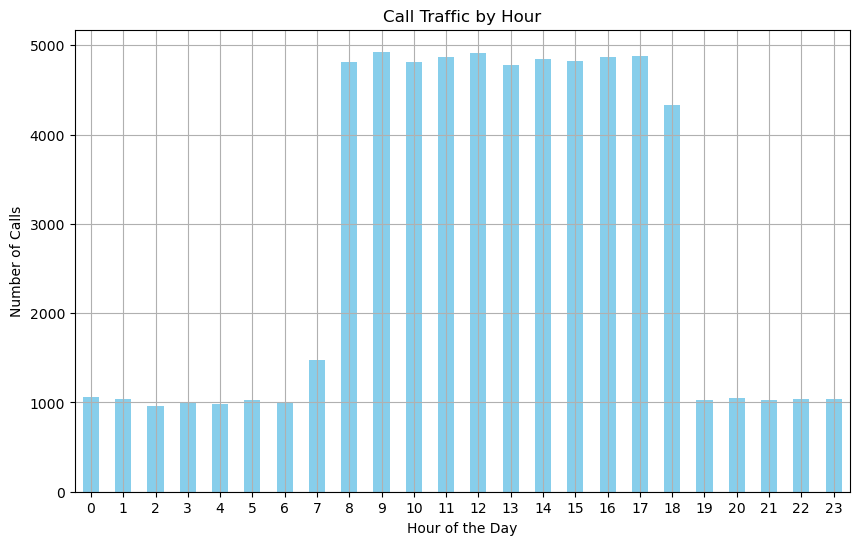

In [133]:
# Extract the hour from call_start_datetime
data['call_start_hour'] = data['call_start_datetime'].dt.hour

# Group by the hour and count the number of calls
call_counts_by_hour = data.groupby('call_start_hour').size()

# Sort the call traffic to find peak hours
peak_hours = call_counts_by_hour.sort_values(ascending=False)

#plot the call traffic by hour

plt.figure(figsize=(10, 6))
call_counts_by_hour.plot(kind='bar', color='skyblue')
plt.title('Call Traffic by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Calls')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

In [101]:
data.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average,waiting_time,handling_time
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,Voluntary Cancel,neutral,angry,-0.04,0.39,7.0,31.0
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,Booking,calm,neutral,0.02,0.35,3.0,12.0
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,NaN,IRROPS,neutral,polite,-0.13,0.32,8.0,19.0
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,Upgrade,neutral,frustrated,-0.20,0.20,5.0,7.0
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,Seating,neutral,polite,-0.05,0.35,10.0,9.0


In [102]:
data.shape

(71810, 16)

In [103]:
data.isnull().sum()

call_id                        0
customer_id                    0
agent_id                       0
call_start_datetime            0
agent_assigned_datetime        0
call_end_datetime              0
call_transcript                0
customer_name                  0
elite_level_code           25767
primary_call_reason         5157
agent_tone                   217
customer_tone                  0
average_sentiment            109
silence_percent_average        0
waiting_time                   0
handling_time                  0
dtype: int64

In [104]:
data.head().transpose()

,0,1,2,3,4
call_id,4667960400,1122072124,6834291559,2266439882,1211603231
customer_id,2033123310,8186702651,2416856629,1154544516,5214456437
agent_id,963118,519057,158319,488324,721730
call_start_datetime,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-07-31 23:59:00,2024-08-01 00:05:00,2024-08-01 00:04:00
agent_assigned_datetime,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:07:00,2024-08-01 00:10:00,2024-08-01 00:14:00
call_end_datetime,2024-08-01 00:34:00,2024-08-01 00:18:00,2024-08-01 00:26:00,2024-08-01 00:17:00,2024-08-01 00:23:00
call_transcript,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...
customer_name,Matthew Foster,Tammy Walters,Jeffery Dixon,David Wilkins,Elizabeth Daniels
elite_level_code,4.0,NaN,NaN,2.0,0.0
primary_call_reason,Voluntary Cancel,Booking,IRROPS,Upgrade,Seating


In [105]:
data_for_pairplot = data.drop(['call_id','customer_id','agent_id', 'call_start_datetime', 'agent_assigned_datetime', 'call_end_datetime'], axis=1)

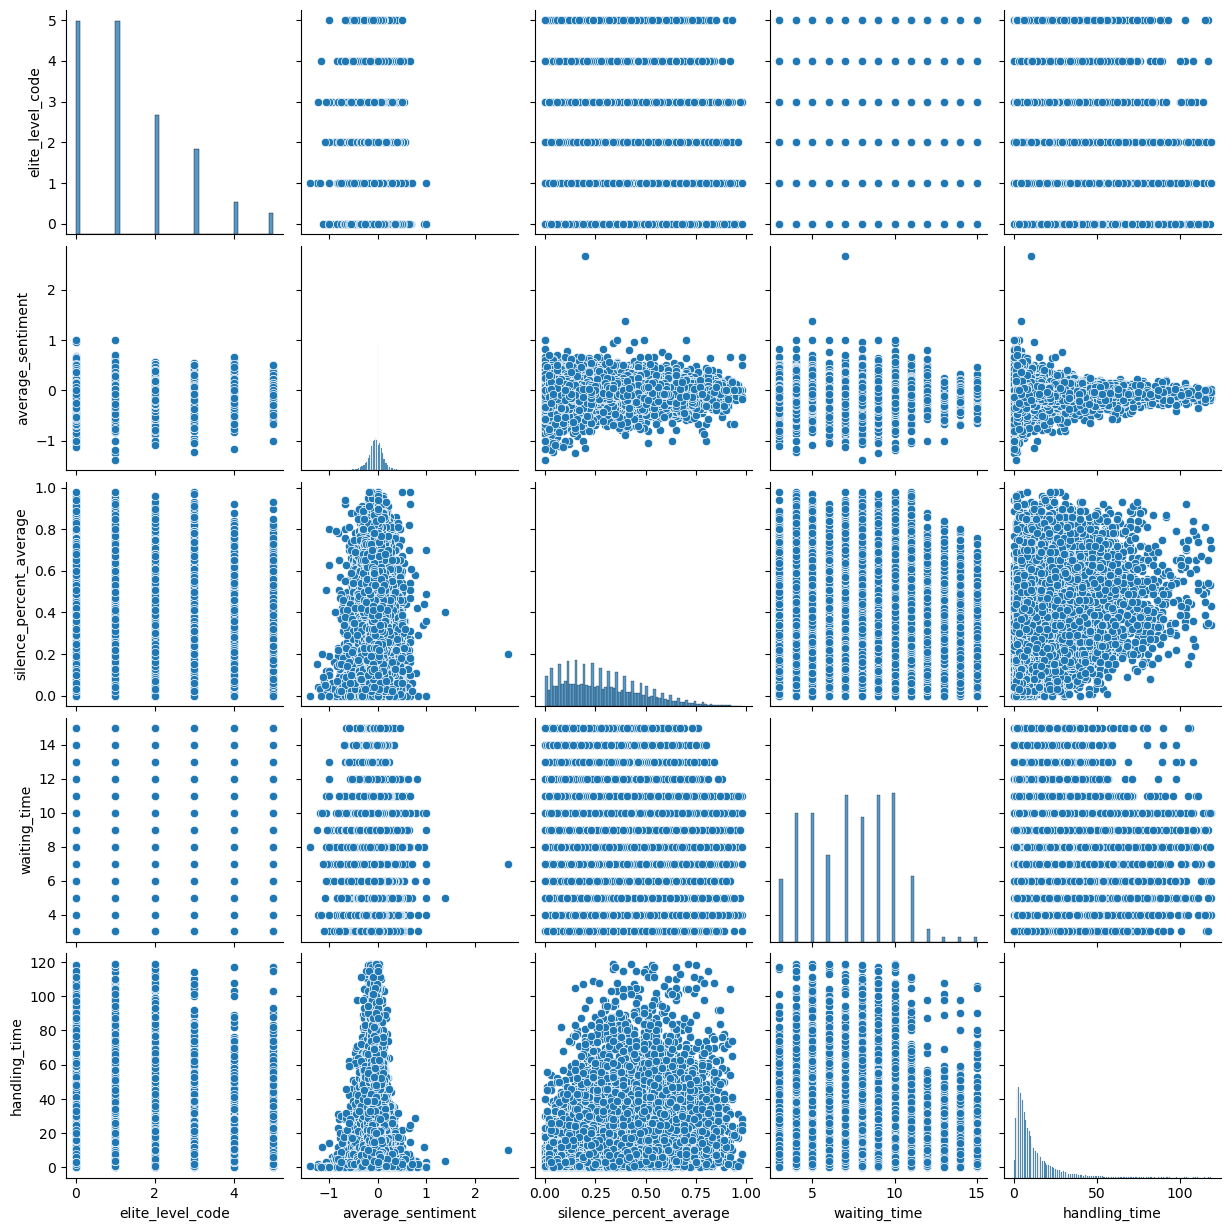

In [106]:
sns.pairplot(data=data_for_pairplot)

<Axes: xlabel='agent_tone', ylabel='handling_time'>

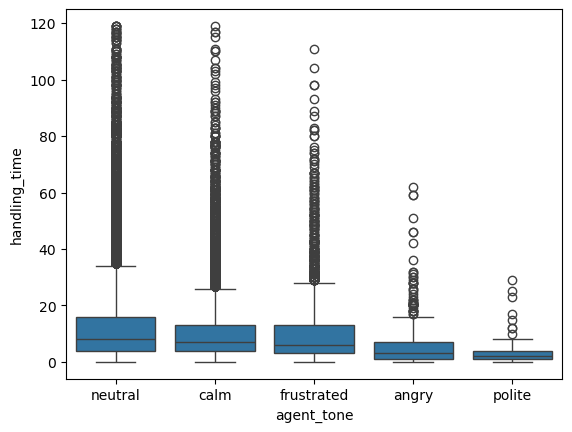

In [107]:
sns.boxplot(x='agent_tone', y='handling_time', data=data)

<Axes: xlabel='agent_tone'>

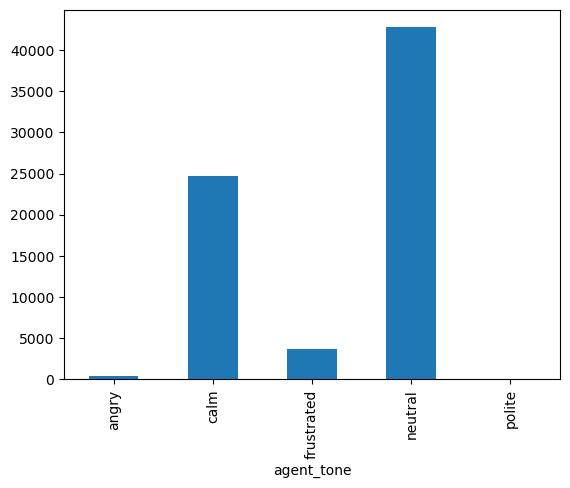

In [108]:
data.groupby('agent_tone').size().plot(kind='bar')

<Axes: xlabel='customer_tone'>

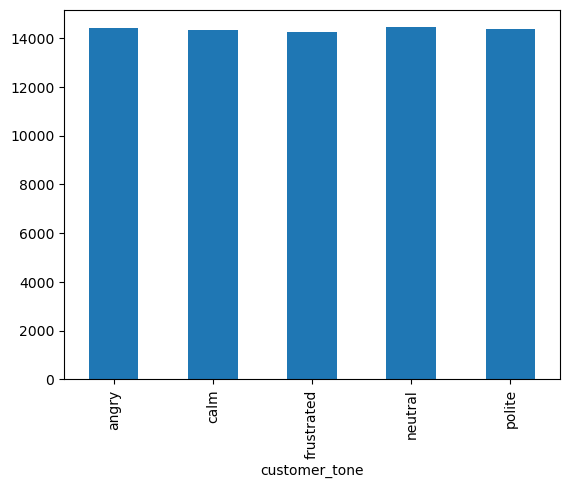

In [109]:
data.groupby('customer_tone').size().plot(kind='bar')

<Axes: >

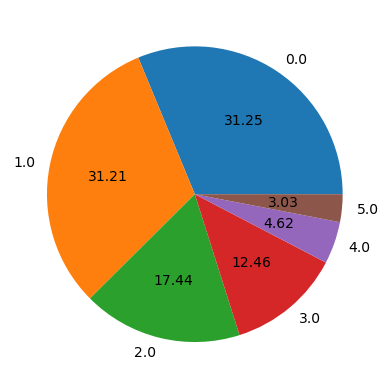

In [110]:
data.groupby('elite_level_code').size().plot(kind='pie', autopct='%.2f')

In [111]:
data.shape

(71810, 16)

In [112]:
print(data.columns)

Index(['call_id', 'customer_id', 'agent_id', 'call_start_datetime',
       'agent_assigned_datetime', 'call_end_datetime', 'call_transcript',
       'customer_name', 'elite_level_code', 'primary_call_reason',
       'agent_tone', 'customer_tone', 'average_sentiment',
       'silence_percent_average', 'waiting_time', 'handling_time'],
      dtype='object')


In [113]:

data['primary_call_reason'] = data['primary_call_reason'].str.replace(' ', '', regex=False)


In [114]:

data['primary_call_reason'].replace('Check-In', 'CheckIn', inplace=True)
data['primary_call_reason'].replace('Post-Flight', 'PostFlight', inplace=True)
data['primary_call_reason'].replace('Products&Services', 'ProductsandServices', inplace=True)



C:\Users\Sushanta\AppData\Local\Temp\ipykernel_9396\749790070.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['primary_call_reason'].replace('Check-In', 'CheckIn', inplace=True)
C:\Users\Sushanta\AppData\Local\Temp\ipykernel_9396\749790070.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

<Axes: xlabel='primary_call_reason'>

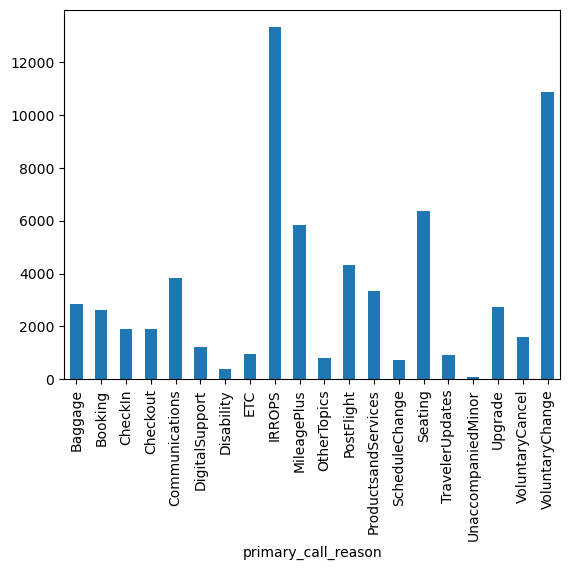

In [115]:
data.groupby('primary_call_reason').size().plot(kind='bar')

In [116]:
# Handling missing values
# Impute 'elite_level_code' with mode (most frequent value)
data['elite_level_code'].fillna(data['elite_level_code'].mode()[0], inplace=True)

C:\Users\Sushanta\AppData\Local\Temp\ipykernel_9396\1652501202.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['elite_level_code'].fillna(data['elite_level_code'].mode()[0], inplace=True)


In [117]:
# Drop rows where 'primary_call_reason' (target) is missing
data.dropna(subset=['primary_call_reason'], inplace=True)

In [118]:
data.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average,waiting_time,handling_time
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,VoluntaryCancel,neutral,angry,-0.04,0.39,7.0,31.0
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,0.0,Booking,calm,neutral,0.02,0.35,3.0,12.0
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,0.0,IRROPS,neutral,polite,-0.13,0.32,8.0,19.0
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,Upgrade,neutral,frustrated,-0.20,0.20,5.0,7.0
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,Seating,neutral,polite,-0.05,0.35,10.0,9.0


In [122]:
# Fill missing values for 'agent_tone' with mode
data['agent_tone'].fillna(data['agent_tone'].mode()[0], inplace=True)

In [127]:
# Fill missing values for 'average_sentiment' with mode
data['average_sentiment'].fillna(data['average_sentiment'].mean(), inplace=True)

C:\Users\Sushanta\AppData\Local\Temp\ipykernel_9396\2816236757.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['average_sentiment'].fillna(data['average_sentiment'].mean(), inplace=True)


In [128]:

# Check if there are any remaining missing values
data.isnull().sum()

call_id                    0
customer_id                0
agent_id                   0
call_start_datetime        0
agent_assigned_datetime    0
call_end_datetime          0
call_transcript            0
customer_name              0
elite_level_code           0
primary_call_reason        0
agent_tone                 0
customer_tone              0
average_sentiment          0
silence_percent_average    0
waiting_time               0
handling_time              0
dtype: int64

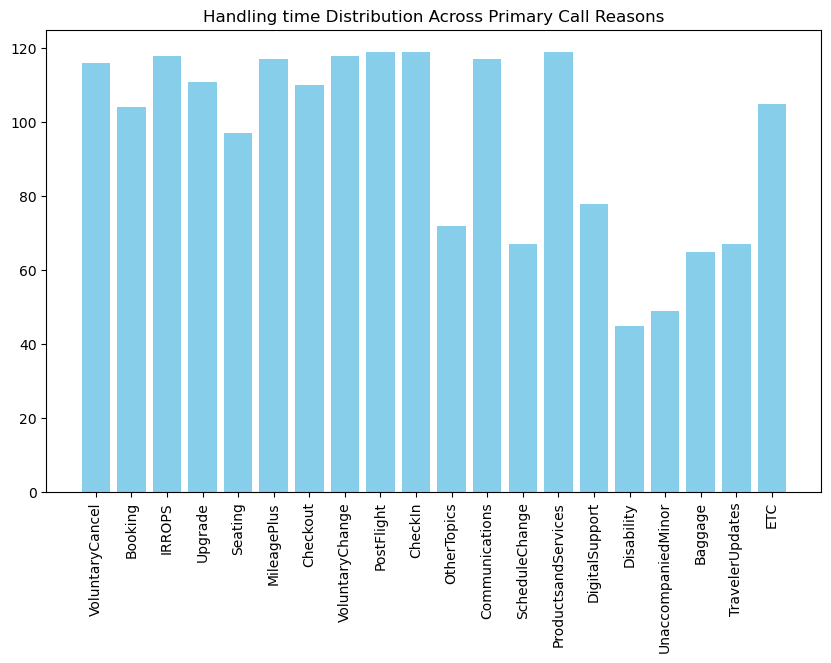

In [124]:
# Checking relationship between sentiment and call reason
plt.figure(figsize=(10, 6))
plt.bar(data['primary_call_reason'], data['handling_time'], color='skyblue')
plt.title('Handling time Distribution Across Primary Call Reasons')
plt.xticks(rotation=90)
plt.show()

In [134]:
data['waiting_time'].describe()

count    66653.000000
mean         7.282868
std          2.519256
min          3.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         15.000000
Name: waiting_time, dtype: float64

<Axes: ylabel='waiting_time'>

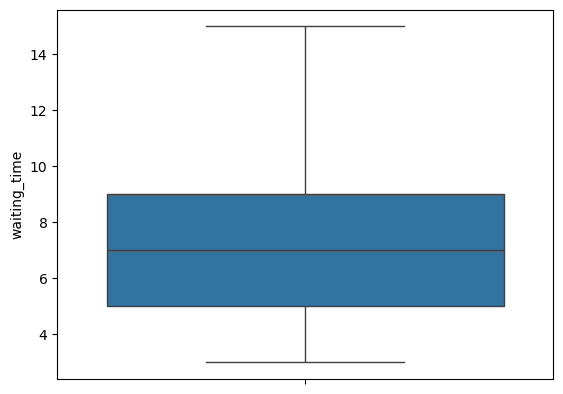

In [135]:
sns.boxplot(y='waiting_time',data=data)

In [136]:
data['handling_time'].describe()

count    66653.000000
mean        11.619612
std         12.905448
min          0.000000
25%          4.000000
50%          7.000000
75%         15.000000
max        119.000000
Name: handling_time, dtype: float64

<Axes: ylabel='handling_time'>

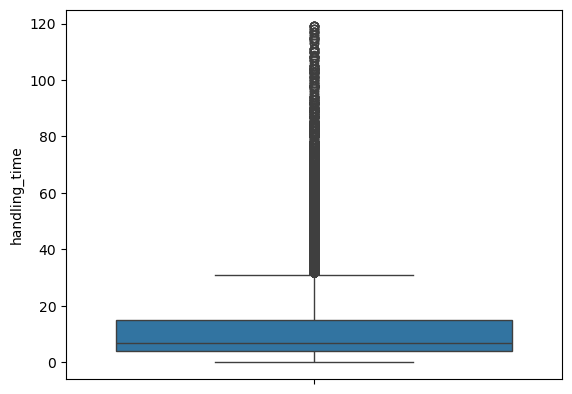

In [137]:
sns.boxplot(y='handling_time',data=data)

Handling time has a lot of outliers.

In [138]:
# IQR calculation for handling time
Q1 = data['handling_time'].quantile(0.25)
Q3 = data['handling_time'].quantile(0.75)
IQR = Q3 - Q1

In [139]:
IQR

11.0

In [140]:
#Extracting the outliers from the dataframe
outliers = data[(data['handling_time'] < (Q1 - 1.5*IQR)) | (data['handling_time'] > (Q3 + 1.5*IQR))]

In [141]:
data = data.drop(outliers.index,axis=0)

<Axes: ylabel='handling_time'>

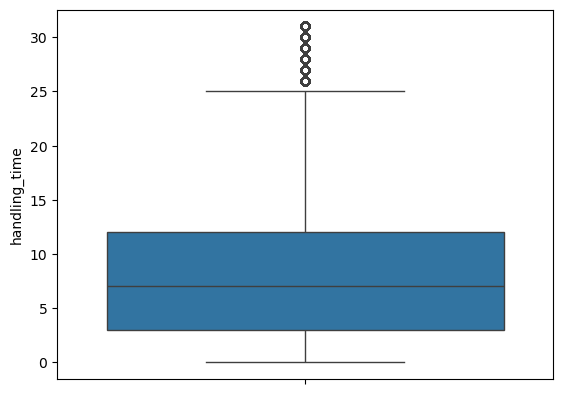

In [142]:
sns.boxplot(y='handling_time',data=data)

In [143]:
data['handling_time'].describe()

count    61953.000000
mean         8.862832
std          7.144852
min          0.000000
25%          3.000000
50%          7.000000
75%         12.000000
max         31.000000
Name: handling_time, dtype: float64

### The Average call handling time(after removing outliers) is approximately 8.863 minutes.

### The Average call duration time(after removing outliers) is approximately 16.152 minutes.

In [144]:
outliers.transpose()

,15,16,34,79,87,98,102,145,155,164,...,71689,71694,71695,71727,71735,71752,71770,71772,71785,71793
call_id,3313876732,9009313118,3107888571,5725811355,3494281557,3182938486,4886165173,4346744236,9761028950,4124838721,...,6550781572,7893513785,5752107797,2861613601,9012625201,3504075766,8727725650,4560172425,5713760779,4035081392
customer_id,6748767796,1937394483,6813371451,1773534882,3732525410,8464019059,9360139623,4031423656,4479774607,174687241,...,4767342163,5855573029,5536802633,1204427078,4110984748,2324618148,4295424012,7907439532,3306855958,4546905380
agent_id,158319,963118,519057,158319,964561,878048,964561,825827,758927,462743,...,764643,937566,175271,872306,336455,780490,506130,335773,102574,370723
call_start_datetime,2024-08-01 00:32:00,2024-08-01 00:38:00,2024-08-01 01:37:00,2024-08-01 04:00:00,2024-08-01 04:36:00,2024-08-01 05:10:00,2024-08-01 05:26:00,2024-08-01 08:08:00,2024-08-01 08:05:00,2024-08-01 08:18:00,...,2024-08-31 22:03:00,2024-08-31 22:10:00,2024-08-31 22:09:00,2024-08-31 22:39:00,2024-08-31 22:40:00,2024-08-31 22:59:00,2024-08-31 23:14:00,2024-08-31 23:18:00,2024-08-31 23:29:00,2024-08-31 23:37:00
agent_assigned_datetime,2024-08-01 00:40:00,2024-08-01 00:47:00,2024-08-01 01:43:00,2024-08-01 04:04:00,2024-08-01 04:45:00,2024-08-01 05:18:00,2024-08-01 05:36:00,2024-08-01 08:12:00,2024-08-01 08:16:00,2024-08-01 08:23:00,...,2024-08-31 22:13:00,2024-08-31 22:15:00,2024-08-31 22:16:00,2024-08-31 22:43:00,2024-08-31 22:49:00,2024-08-31 23:08:00,2024-08-31 23:21:00,2024-08-31 23:22:00,2024-08-31 23:38:00,2024-08-31 23:45:00
call_end_datetime,2024-08-01 01:13:00,2024-08-01 01:31:00,2024-08-01 02:21:00,2024-08-01 04:46:00,2024-08-01 05:31:00,2024-08-01 05:50:00,2024-08-01 06:20:00,2024-08-01 09:04:00,2024-08-01 08:49:00,2024-08-01 08:55:00,...,2024-08-31 23:11:00,2024-08-31 23:08:00,2024-08-31 22:49:00,2024-08-31 23:15:00,2024-08-31 23:52:00,2024-08-31 23:47:00,2024-09-01 00:09:00,2024-08-31 23:55:00,2024-09-01 01:33:00,2024-09-01 00:18:00
call_transcript,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...,\n\nAgent: Thank you for calling United Airlin...
customer_name,Joseph Madden,Alicia Humphrey,Jillian Evans,Kevin Baxter,Barbara Rodriguez,Diana Kim,Thomas Salazar,Joshua Brown,Brenda Byrd,Shannon Patel,...,Kathryn Hansen,Heather Cunningham,David Camacho,Kelly Porter,David Valdez,Rachel Williams,Jonathan King,Helen Hernandez,Kathleen Johnson,Lisa Woods
elite_level_code,0.0,0.0,1.0,1.0,1.0,3.0,2.0,0.0,2.0,2.0,...,0.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,5.0,0.0
primary_call_reason,CheckIn,PostFlight,MileagePlus,ScheduleChange,Seating,MileagePlus,PostFlight,IRROPS,VoluntaryChange,IRROPS,...,PostFlight,MileagePlus,MileagePlus,Communications,PostFlight,Checkout,VoluntaryCancel,Upgrade,PostFlight,IRROPS


In [145]:
data_for_pairplot_outliers_removed = data.drop(['call_id','customer_id','agent_id', 'call_start_datetime', 'agent_assigned_datetime', 'call_end_datetime'], axis=1)

<Figure size 1000x600 with 0 Axes>

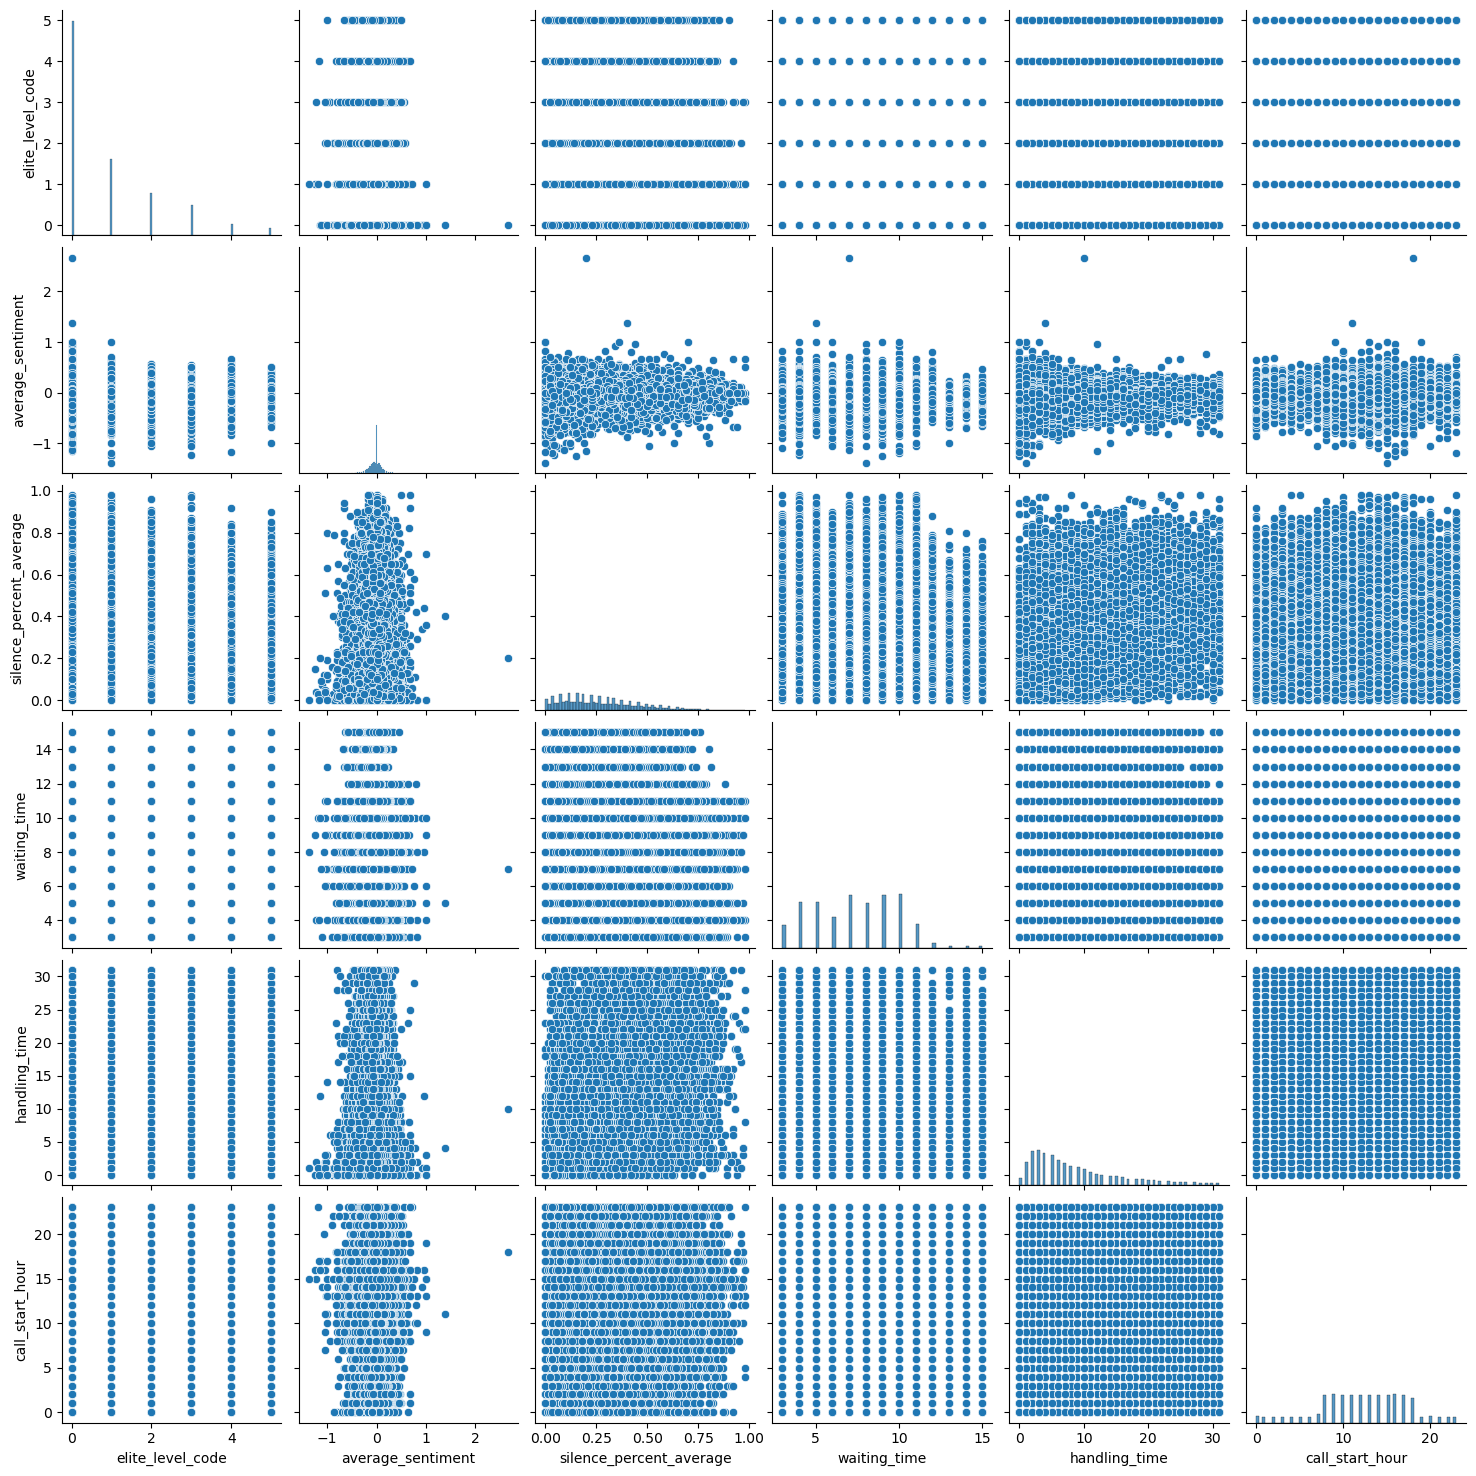

In [148]:
plt.figure(figsize=(10,6))
sns.pairplot(data=data_for_pairplot_outliers_removed)

In [149]:
# Convert categorical columns (agent_tone, customer_tone) into one-hot encoding
categorical_cols = ['agent_tone', 'customer_tone']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

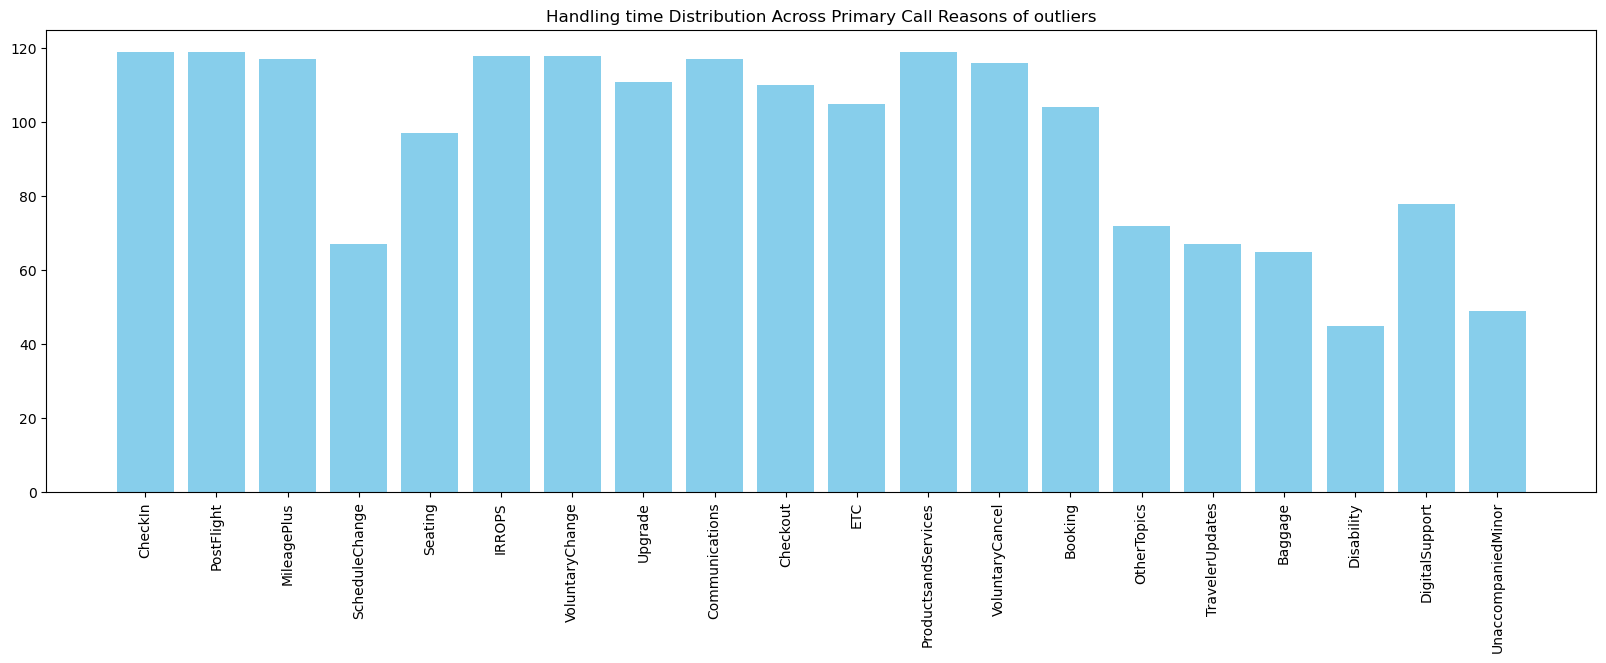

In [150]:
plt.figure(figsize=(20, 6)) 
plt.bar(outliers['primary_call_reason'], outliers['handling_time'], color='skyblue') 
plt.title('Handling time Distribution Across Primary Call Reasons of outliers')
plt.xticks(rotation=90)
plt.show()

In [151]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sushanta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sushanta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [152]:
# Preprocess the Call Transcripts
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    # Tokenize, remove stopwords and non-alphabetic tokens
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)


In [153]:
data['cleaned_transcript'] = data['call_transcript'].dropna().apply(preprocess_text)

In [154]:
data.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,...,call_start_hour,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,customer_tone_calm,customer_tone_frustrated,customer_tone_neutral,customer_tone_polite,cleaned_transcript
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,VoluntaryCancel,...,23,False,False,True,False,False,False,False,False,agent thank calling united airlines customer s...
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,0.0,Booking,...,0,True,False,False,False,False,False,True,False,agent thank calling united airlines name sam h...
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,0.0,IRROPS,...,23,False,False,True,False,False,False,False,True,agent thank calling united airlines customer s...
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,Upgrade,...,0,False,False,True,False,False,True,False,False,agent thank calling united airlines customer s...
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,Seating,...,0,False,False,True,False,False,False,False,True,agent thank calling united airlines customer s...


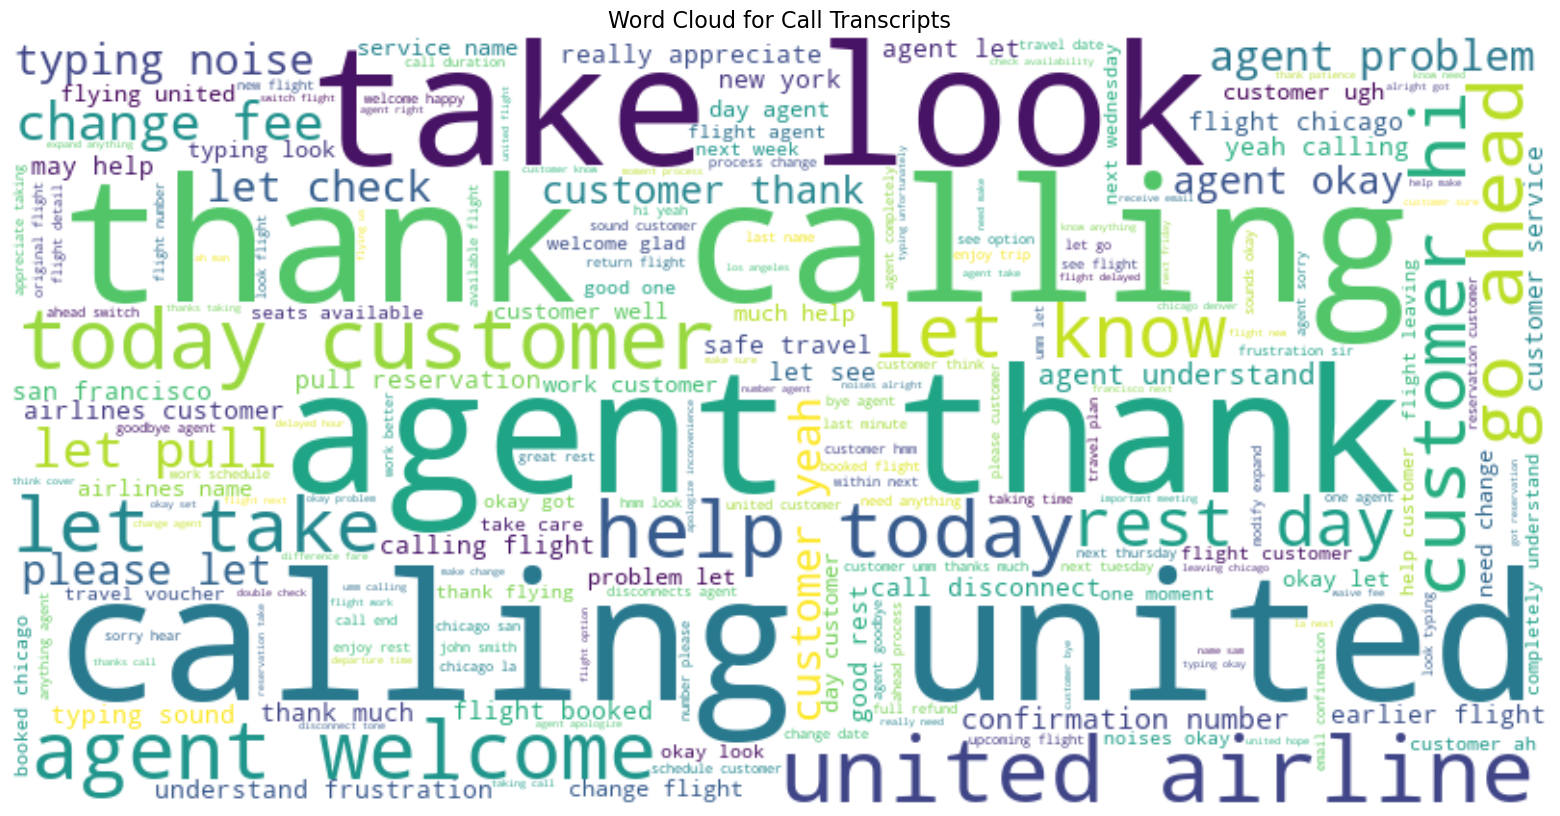

In [155]:
### Word Cloud to Visualize Common Words in Transcripts ###
all_transcripts = ' '.join(data['cleaned_transcript'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(all_transcripts)

# Plot the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Call Transcripts', fontsize=16)
plt.show()

In [156]:
 #Basic keyword-based intent detection to identify common self-solvable issues
def detect_intent(text):
    if 'password' in text or 'reset' in text:
        return 'Password Reset'
    elif 'billing' in text or 'refund' in text:
        return 'Billing/Refund Inquiry'
    elif 'status' or 'delay' in text:
        return 'Flight Status Inquiry'
    elif 'account' in text or 'manage' in text:
        return 'Account Management'
    elif 'baggage' in text or 'checkin' in text or 'checkout' in text or 'disability' in text:
        return 'Aiport Services'    
    else:
        return 'Other'

data['detected_intent'] = data['cleaned_transcript'].apply(detect_intent)

detected_intent
Flight Status Inquiry     49286
Billing/Refund Inquiry    12629
Password Reset               38
Name: count, dtype: int64


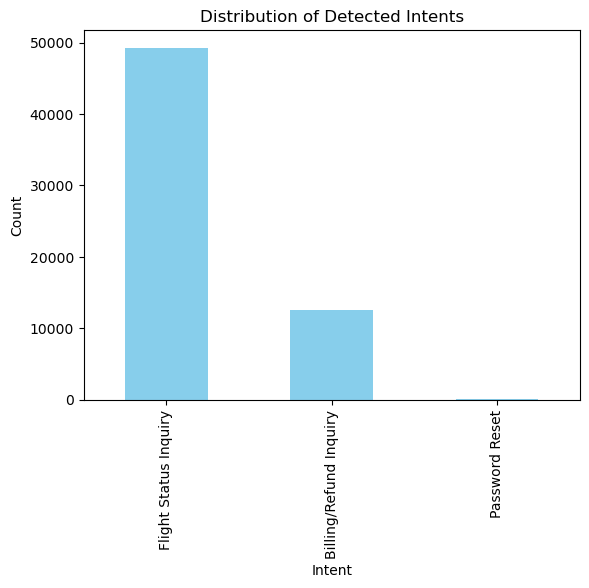

In [157]:
# Analyze the distribution of detected intents
intent_counts = data['detected_intent'].value_counts()
print(intent_counts)

# Plot the distribution of detected intents
intent_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Detected Intents')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.show()


In [158]:
# Now that we have identified the major self-solvable issues, we can propose IVR improvements:
# Example: Print out the IVR self-service recommendations based on the detected issues.
for intent, count in intent_counts.items():
    if intent == 'Password Reset':
        print(f"Recommendation: Implement a self-service option for {intent}. Identified {count} cases.")
    elif intent == 'Billing/Refund Inquiry':
        print(f"Recommendation: Automate billing inquiries in the IVR. Identified {count} cases.")
    elif intent == 'Flight Status Inquiry':
        print(f"Recommendation: Provide real-time flight information in the IVR. Identified {count} cases.")
    elif intent == 'Account Management':
        print(f"Recommendation: Enhance self-service for account management in the IVR. Identified {count} cases.")
    else:
        print(f"Recommendation: Review other issues for further IVR improvements. Identified {count} cases.")

Recommendation: Provide real-time flight information in the IVR. Identified 49286 cases.
Recommendation: Automate billing inquiries in the IVR. Identified 12629 cases.
Recommendation: Implement a self-service option for Password Reset. Identified 38 cases.


In [162]:
data.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,...,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,customer_tone_calm,customer_tone_frustrated,customer_tone_neutral,customer_tone_polite,cleaned_transcript,detected_intent,encoded_call_reason
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,VoluntaryCancel,...,False,True,False,False,False,False,False,agent thank calling united airlines customer s...,Flight Status Inquiry,18
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,0.0,Booking,...,False,False,False,False,False,True,False,agent thank calling united airlines name sam h...,Flight Status Inquiry,1
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,0.0,IRROPS,...,False,True,False,False,False,False,True,agent thank calling united airlines customer s...,Flight Status Inquiry,8
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,Upgrade,...,False,True,False,False,True,False,False,agent thank calling united airlines customer s...,Flight Status Inquiry,17
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,Seating,...,False,True,False,False,False,False,True,agent thank calling united airlines customer s...,Flight Status Inquiry,14


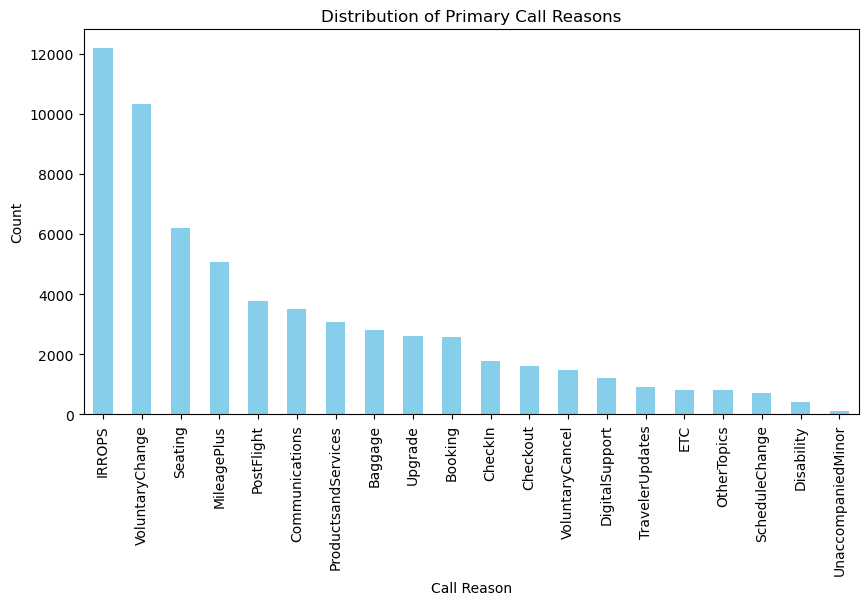

In [163]:

# Visualize call reason distribution
plt.figure(figsize=(10, 5))
data['primary_call_reason'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Primary Call Reasons')
plt.xlabel('Call Reason')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [164]:
# Feature Engineering
# Encode the target variable
label_encoder = LabelEncoder()
data['encoded_call_reason'] = label_encoder.fit_transform(data['primary_call_reason'])

In [161]:
# Create a pipeline for TF-IDF vectorization and Random Forest model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),  # Limit to top 1000 features
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_transcript'], data['encoded_call_reason'], 
                                                    test_size=0.2, random_state=42)

In [ ]:
# Model Training
pipeline.fit(X_train, y_train)

In [ ]:
# Model Evaluation
y_pred = pipeline.predict(X_test)

In [ ]:
# Classification report and confusion matrix
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
confusion_mtx = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_mtx)

In [ ]:
# Visualize confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000)),  # Vectorization of text data
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42))  # MLP model
])


In [ ]:
# Model Training
pipeline.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

### Detecting factors affecting AHT and AST

In [ ]:
# EDA - Average Handle Time (AHT) by Call Type
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='call_reason', y='AHT', palette='Set2')
plt.title('AHT Distribution by Call Reason')
plt.xticks(rotation=45)
plt.ylabel('Average Handle Time (AHT)')
plt.xlabel('Call Reason')
plt.show()


In [ ]:

plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='agent_performance', y='AHT', palette='Set1')
plt.title('Average Handle Time (AHT) by Agent Performance')
plt.ylabel('Average Handle Time (AHT)')
plt.xlabel('Agent Performance')
plt.show()

In [ ]:

plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='average_sentiment', y='handling_time', palette='Set3')
plt.title('Average Handle Time (AHT) by Sentiment')
plt.ylabel('Average Handle Time (AHT)')
plt.xlabel('Sentiment')
plt.show()

In [ ]:
data.head().transpose()


In [ ]:

# This can be done using correlation or regression analysis
correlation_matrix = data[['handling_time', 'average_sentiment', 'waiting_time', 'elite_level_code', 'agent_tone_calm', 'agent_tone_frustrated', 'agent_tone_neutral', 'agent_tone_polite', 'customer_tone_calm', 'silence_percent_average', 'customer_tone_frustrated', 'customer_tone_neutral', 'customer_tone_polite', 'transcript_cluster', 'encoded_call_reason']].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Calculate Percentage Difference Between AHT for Most and Least Frequent Call Reasons
# Get AHT for each call_reason
aht_by_reason = data.groupby('primary_call_reason')['handling_time'].mean().reset_index()
most_frequent_reason = data['primary_call_reason'].value_counts().idxmax()
least_frequent_reason = data['primary_call_reason'].value_counts().idxmin()


In [ ]:
# Calculate the AHT for the most and least frequent call reasons
most_frequent_aht = aht_by_reason[aht_by_reason['primary_call_reason'] == most_frequent_reason]['handling_time'].values[0]
least_frequent_aht = aht_by_reason[aht_by_reason['primary_call_reason'] == least_frequent_reason]['handling_time'].values[0]

In [ ]:
# Calculate percentage difference
percentage_difference = ((most_frequent_aht - least_frequent_aht) / least_frequent_aht) * 100

In [ ]:
print(f"Average Handling Time for Most Frequent Call Reason ({most_frequent_reason}): {most_frequent_aht:.2f}")
print(f"Average Handling Time for Least Frequent Call Reason ({least_frequent_reason}): {least_frequent_aht:.2f}")
print(f"Percentage Difference in AHT: {percentage_difference:.2f}%")